## Práctica 2
En esta práctica vamos a trabajar con datos socioeconómicos de distintos paises con el objetivo de realizar un análisis de clustering que permita determinar si se pueden establecer grupos de paises a partir de esta clase de datos.

El dataset tendrán que descargarlo del siguiente [link](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data). Luego pueden importarlo a su sesión de Colab directamente desde sus PC locales o ubicarlo en su Drive.

Tienen que probar por lo menos una de las técnicas de clustering vistas en clase, utilizando distintos criterios a la hora generar los clusters. Luego realizar una validación interna de los resultados.

**EXTRA:** En el dataset no hay ninguna variable que agrupe a los paises en distintas categorias que nos permita realizar una validación cruzada. ¿Se les ocurre qué tipo de información externa podría usar para este problema? ¿Se animan a crear una variable de este tipo a partir del criterio elegido?

# Carga de librerias

In [ ]:
!pip install kneed

In [ ]:
#Librerias generales
import numpy as np
import pandas as pd
from random import sample
from numpy.random import uniform
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Otros
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import silhouette_visualizer
from kneed import KneeLocator

carga de datos:

In [ ]:
df = pd.read_csv('Country-data.csv')

In [ ]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# EDA

In [ ]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


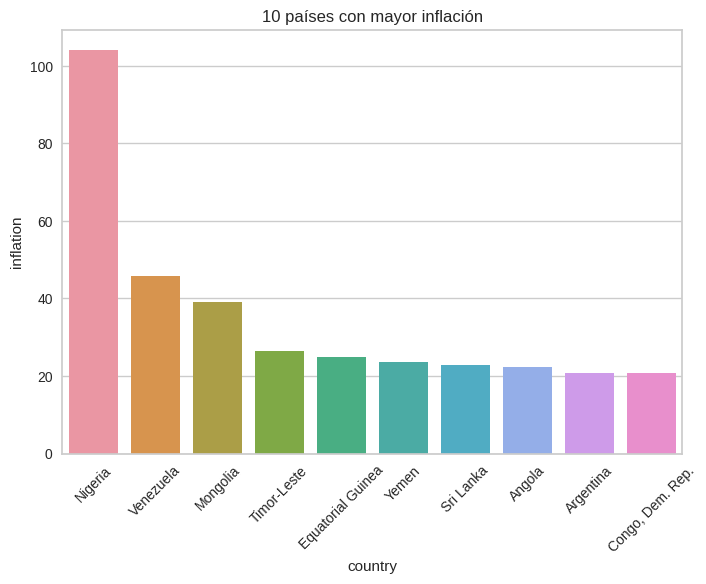

In [ ]:
dfInflation = df.sort_values(by='inflation', ascending=False).head(10)
dfInflation = dfInflation.reset_index(drop=True)
#hago comenzar el index en 1
dfInflation.index = dfInflation.index + 1
ax = sns.barplot(data=dfInflation, x="country", y="inflation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('10 países con mayor inflación')
plt.show()

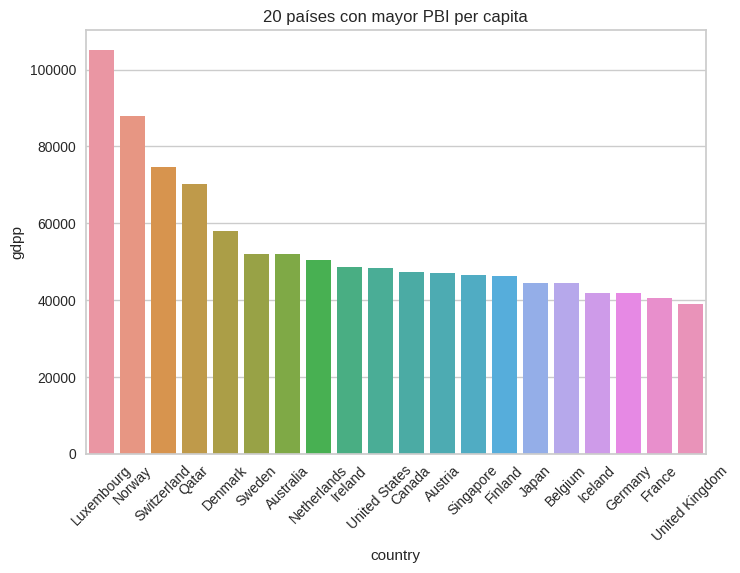

In [ ]:
dfPBI = df.sort_values(by='gdpp', ascending=False).head(20)
dfPBI = dfPBI.reset_index(drop=True)
dfPBI.index = dfPBI.index + 1
ax = sns.barplot(data=dfPBI, x="country", y="gdpp")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('20 países con mayor PBI per capita')
plt.show()

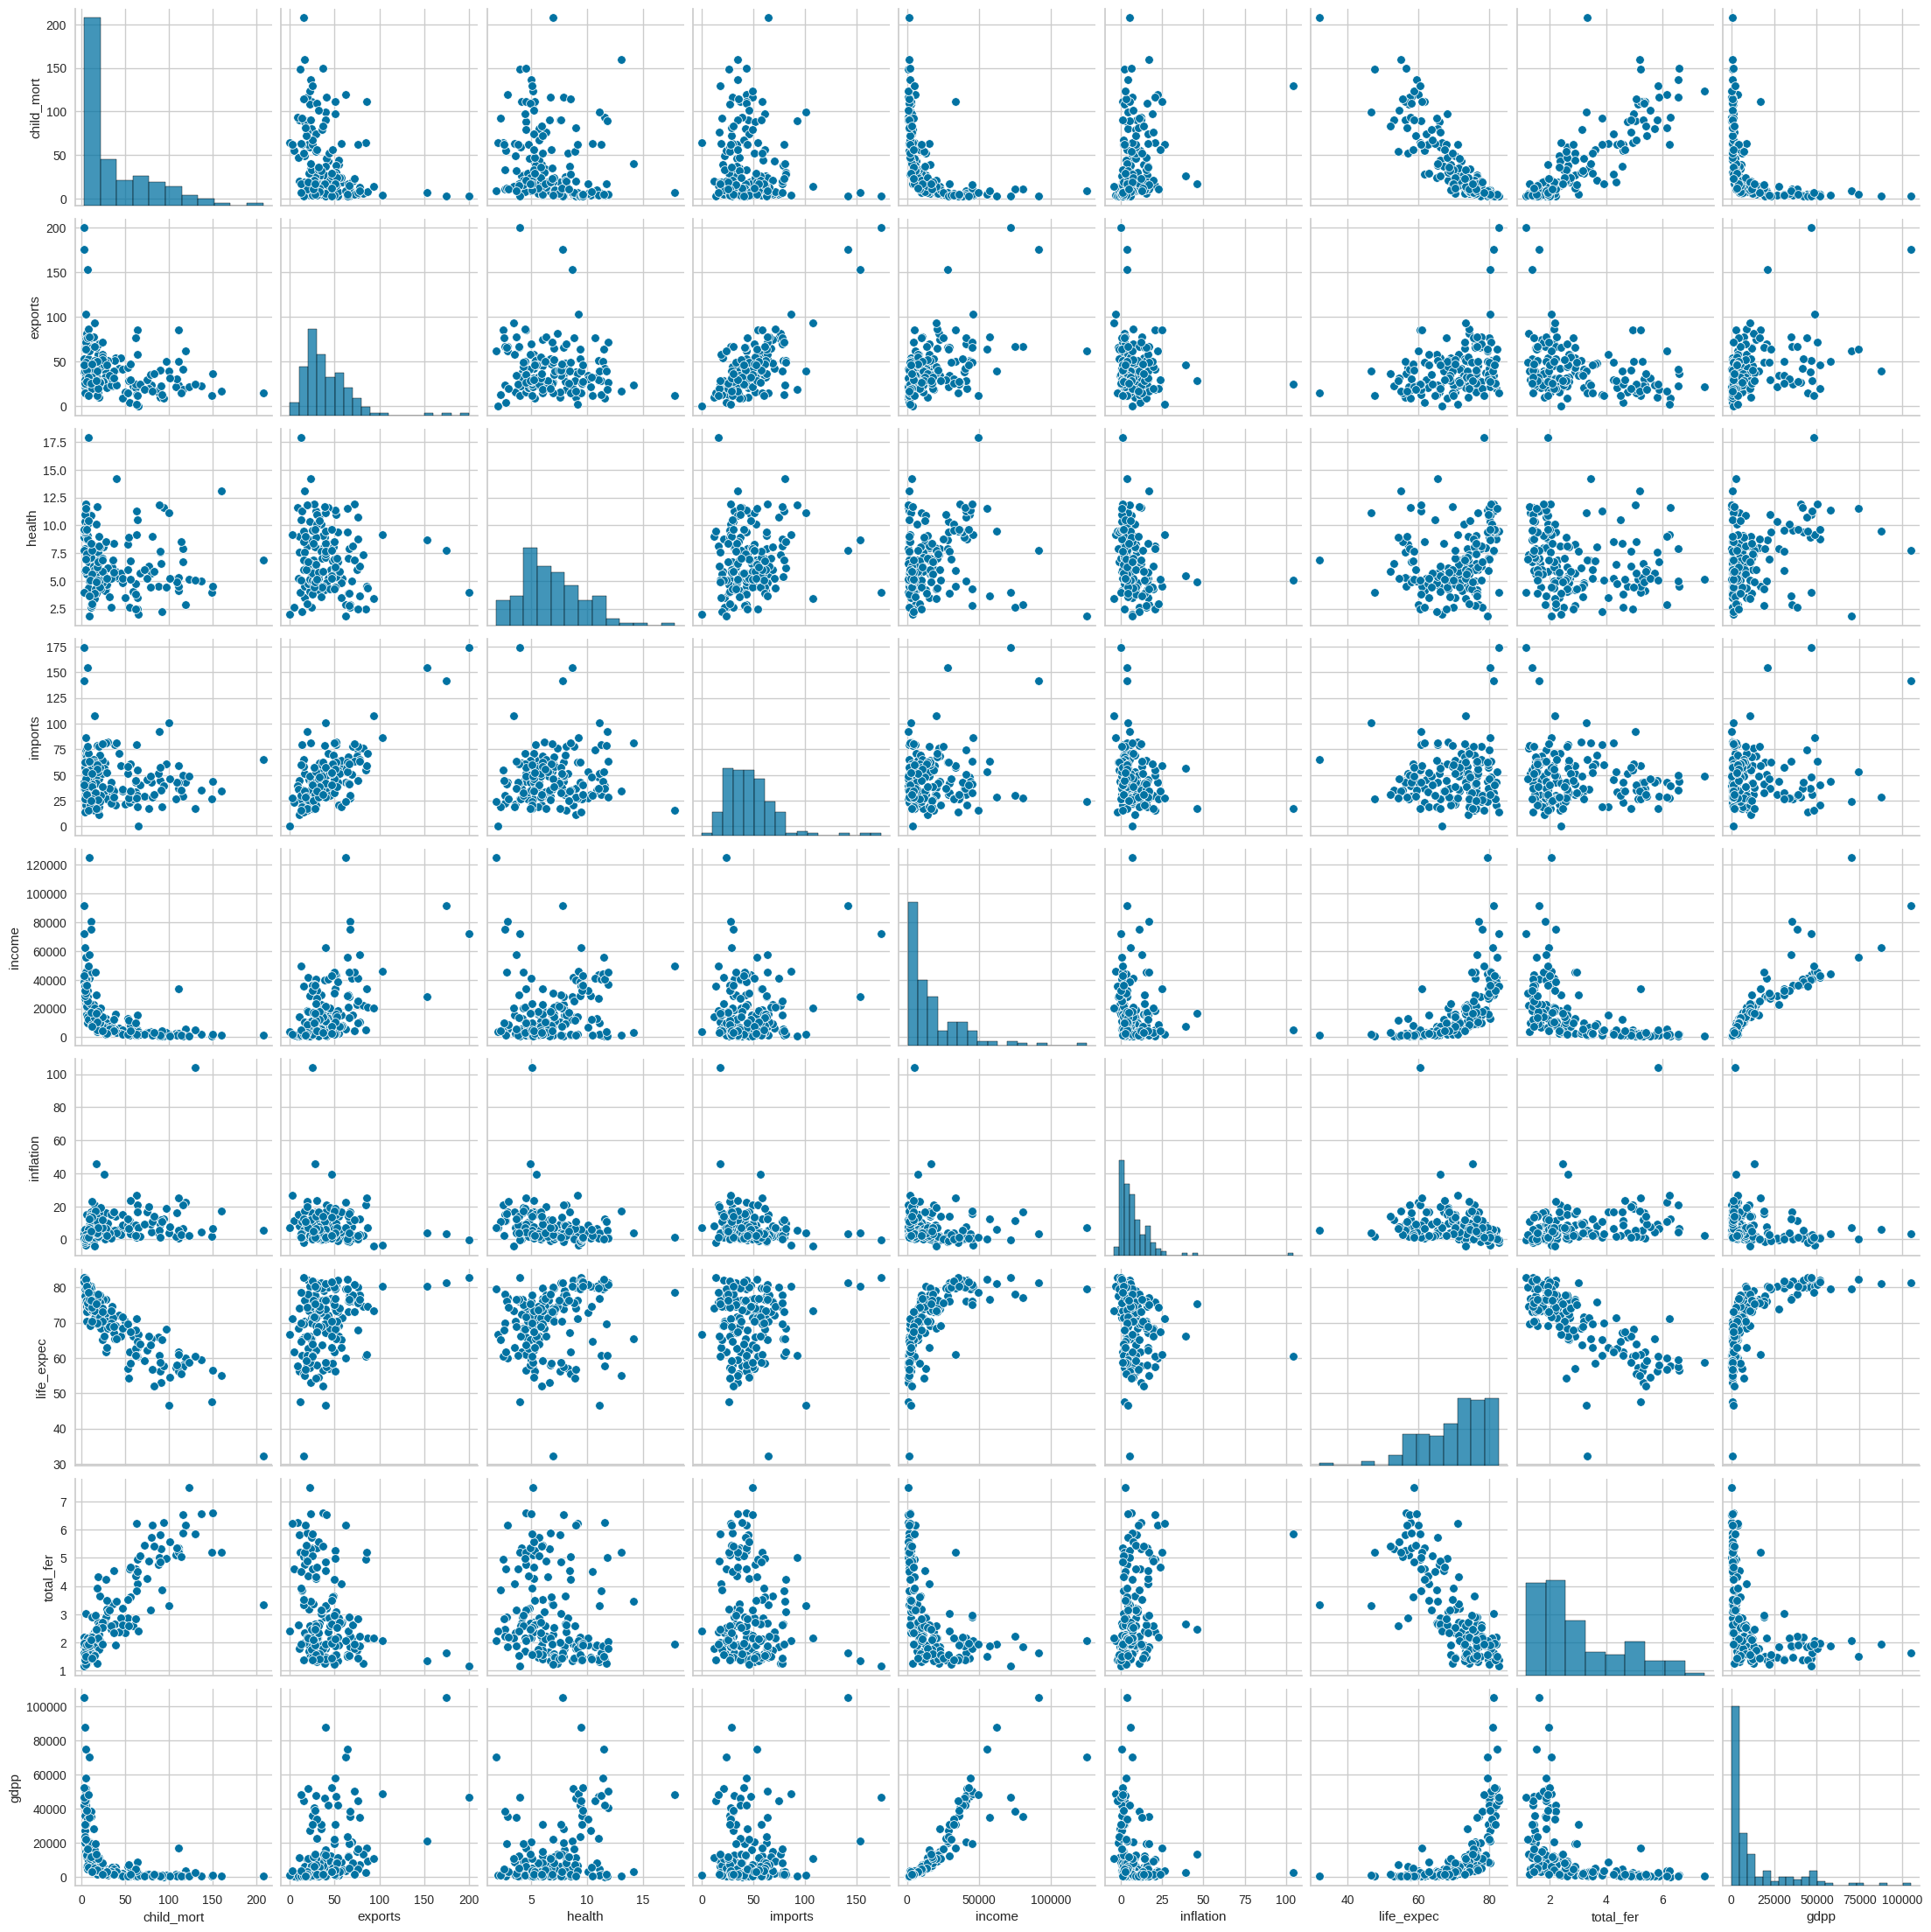

In [ ]:
sns.pairplot(df)

haciendo zoom en alguno de los gráficos de dispersión:

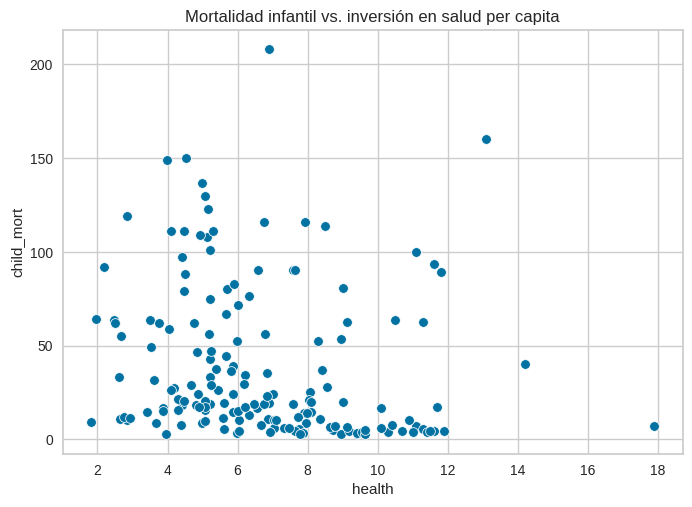

In [ ]:
ax = sns.scatterplot(x='health',
                y='child_mort',
                data=df)
ax.set_title('Mortalidad infantil vs. inversión en salud per capita')
plt.show()

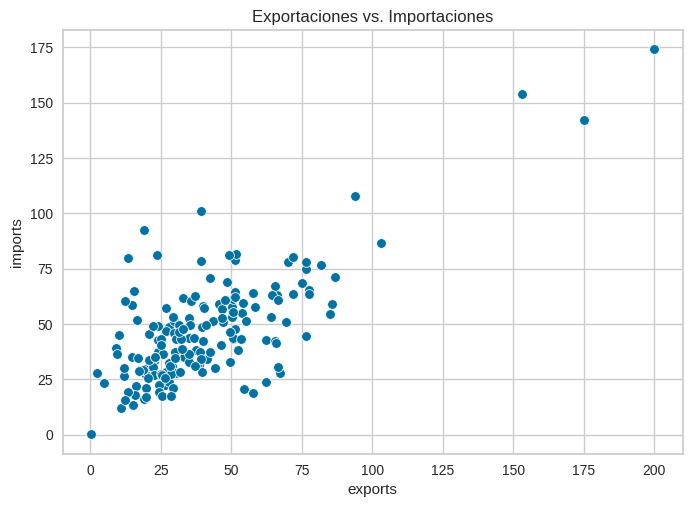

In [ ]:
ax = sns.scatterplot(x='exports',
                y='imports',
                data=df)
ax.set_title('Exportaciones vs. Importaciones')
plt.show()

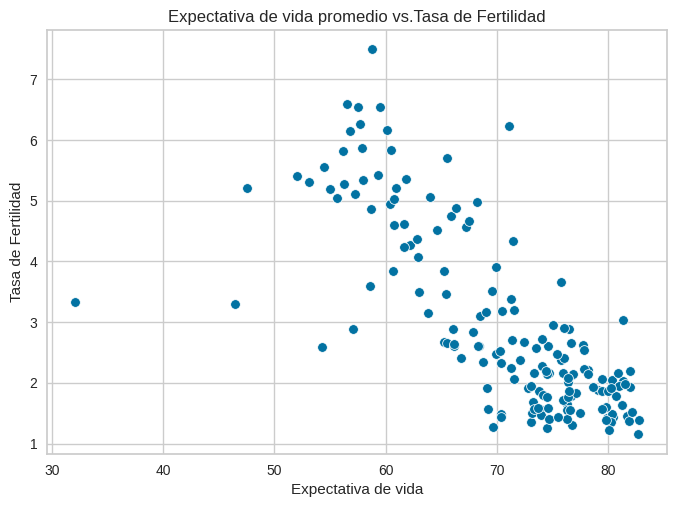

In [ ]:
ax = sns.scatterplot(x='life_expec',
                y='total_fer',
                data=df)
ax.set_title('Expectativa de vida promedio vs.Tasa de Fertilidad')
ax.set_ylabel('Tasa de Fertilidad')
ax.set_xlabel('Expectativa de vida')
plt.show()

# Preprocesamiento

Estandarización de datos:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [ ]:
df1 = df.drop('country', axis=1, inplace=False)
cols = df1.columns

In [ ]:
#Estandarizacion
scaler = StandardScaler()
scaled = scaler.fit_transform(df1)
df1 = pd.DataFrame(scaled, columns = cols)
df1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-3.722904e-17,2.127373e-16,5.504579e-16,2.765585e-16,-7.977650e-17,-1.063687e-17,3.696311e-16,3.044803e-16,5.850277e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00,-6.968005e-01
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-6.366596e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.544309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01,5.942100e-02
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00,5.036507e+00


## estadístico de Hopkins

In [ ]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):

    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H



In [ ]:
H = hopkins_statistic(df1)
print(H)

0.8913151757341305


In [ ]:
#Cómo el valor de este estadístico depende de una comparación con una muestra aleatoria, lo vamos a calcular varias veces y promediar los distintos valores.
#De esta forma obtenemos un valor más consistente
l = []
for i in range(20):
    H=hopkins_statistic(df1)
    l.append(H)
#Valor del estadístico Hopkins promedio
np.mean(l)

0.8561907774076666

# Reducción de la dimensionalidad(PCA)

In [ ]:
#Realizamos el PCA
pca = PCA(n_components=2) #Vamos a representar nuestros datos en 2 dimensiones
principalComponents = pca.fit_transform(df1)
dfPCA = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_1', 'principal_component_2'])

In [ ]:
dfPCA.head()

,principal_component_1,principal_component_2
0,-2.913025,0.095621
1,0.429911,-0.588156
2,-0.285225,-0.455174
3,-2.932423,1.695555
4,1.033576,0.136659


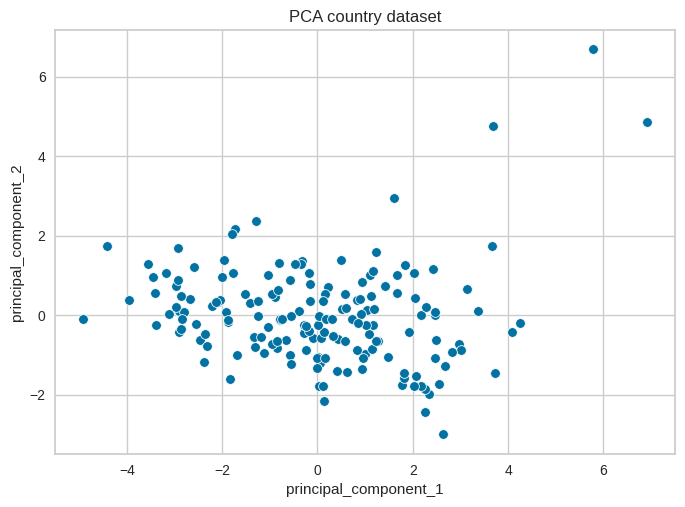

In [ ]:
#Graficamos la distribución de nuestros puntos en este nuevo espacio
ax = sns.scatterplot(x='principal_component_1',
                y='principal_component_2',
                data=dfPCA)
ax.set_title('PCA country dataset')
plt.show()

creamos un dataframe para visualizar y comparar clusters:

In [ ]:
# Suponiendo que df1 y dfPCA tienen el mismo índice
df_cluster = pd.concat([df1, dfPCA[['principal_component_1', 'principal_component_2']]], axis=1)

# Verifica el resultado
df_cluster


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,principal_component_1,principal_component_2
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,-2.913025,0.095621
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0.429911,-0.588156
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,-0.285225,-0.455174
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,-2.932423,1.695555
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,1.033576,0.136659
...,...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913,-0.820631,0.639570
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323,-0.551036,-1.233886
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754,0.498524,1.390744
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754,-1.887451,-0.109453


# Clustering jerárquico

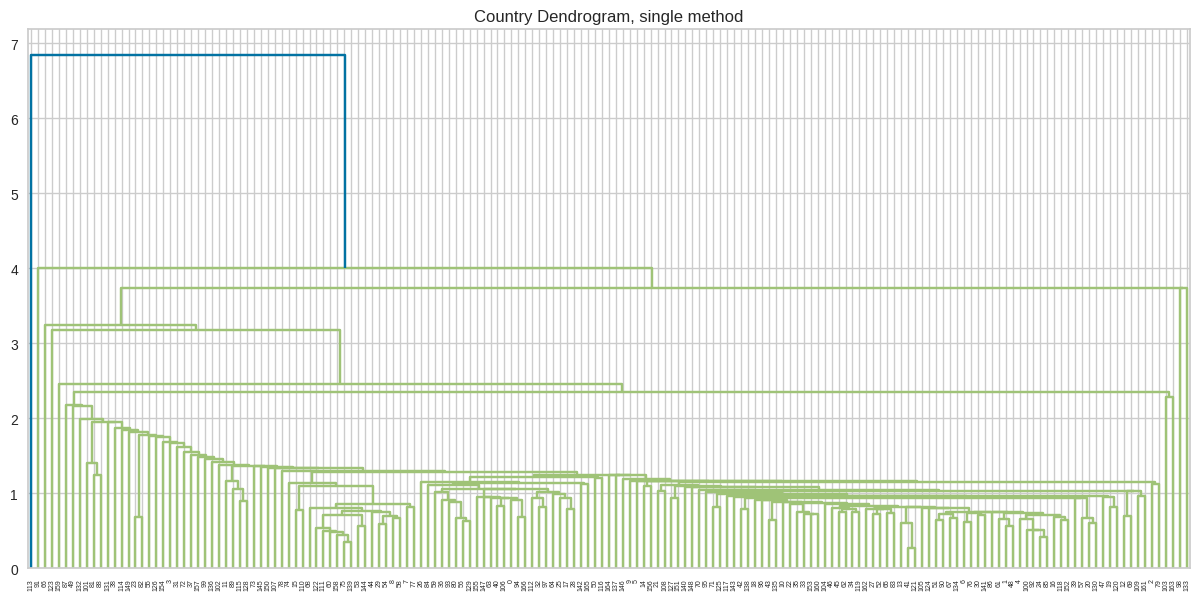

In [ ]:
#Single linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram, single method")

clusters = shc.linkage(df1,
            method='single',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

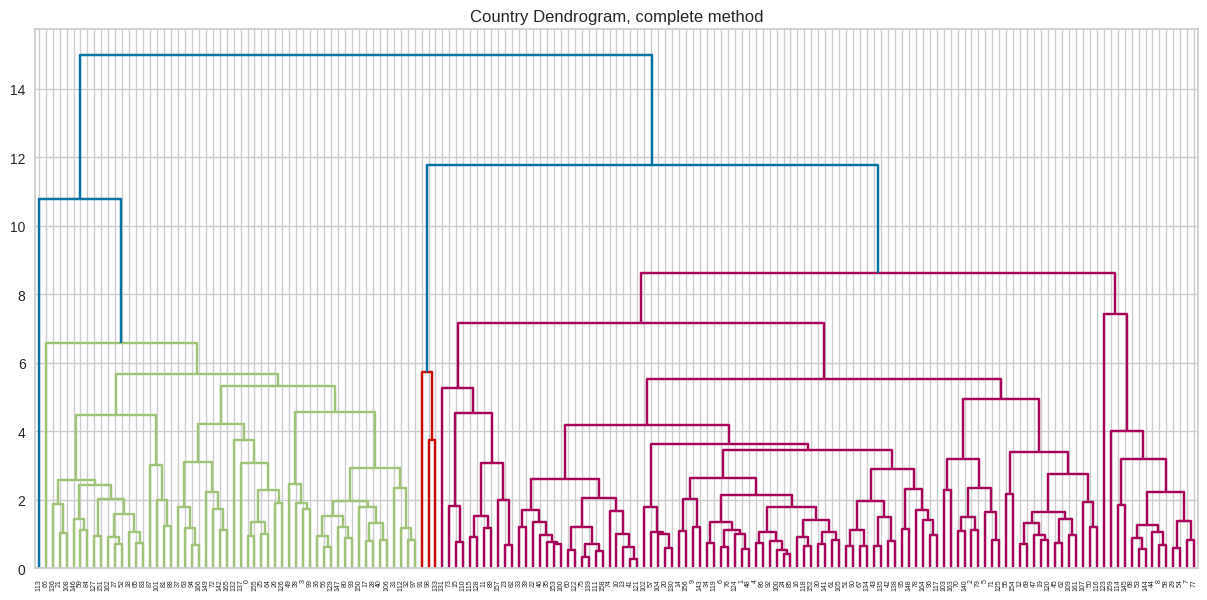

In [ ]:
#Complete linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram, complete method")

clusters = shc.linkage(df1,
            method='complete',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

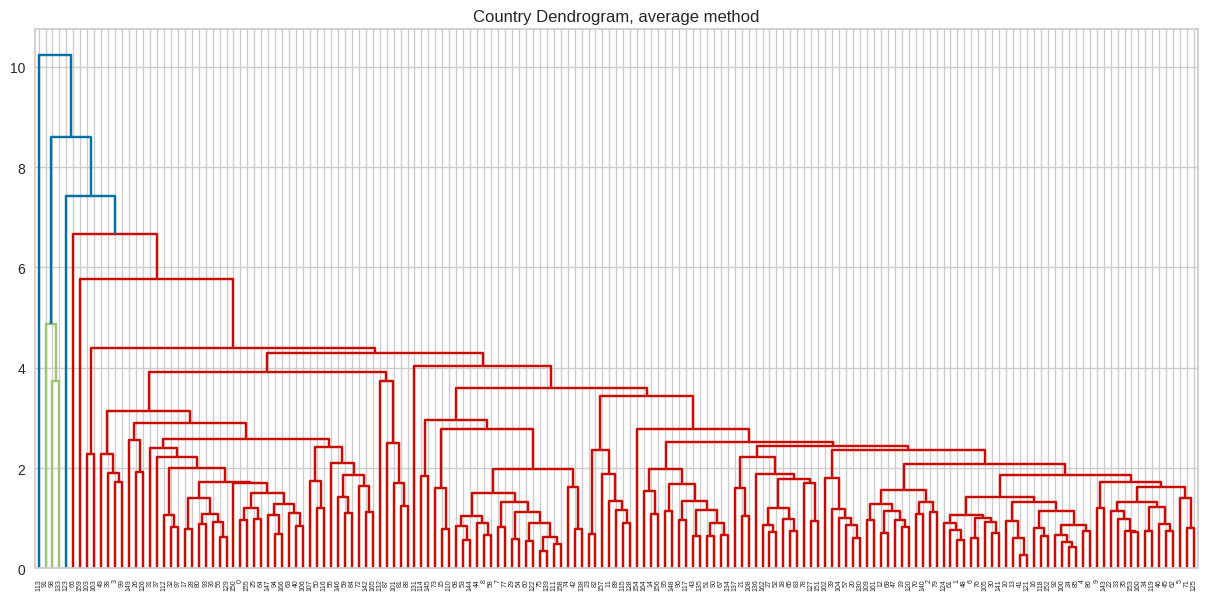

In [ ]:
#Average linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram, average method")

clusters = shc.linkage(df1,
            method='average',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

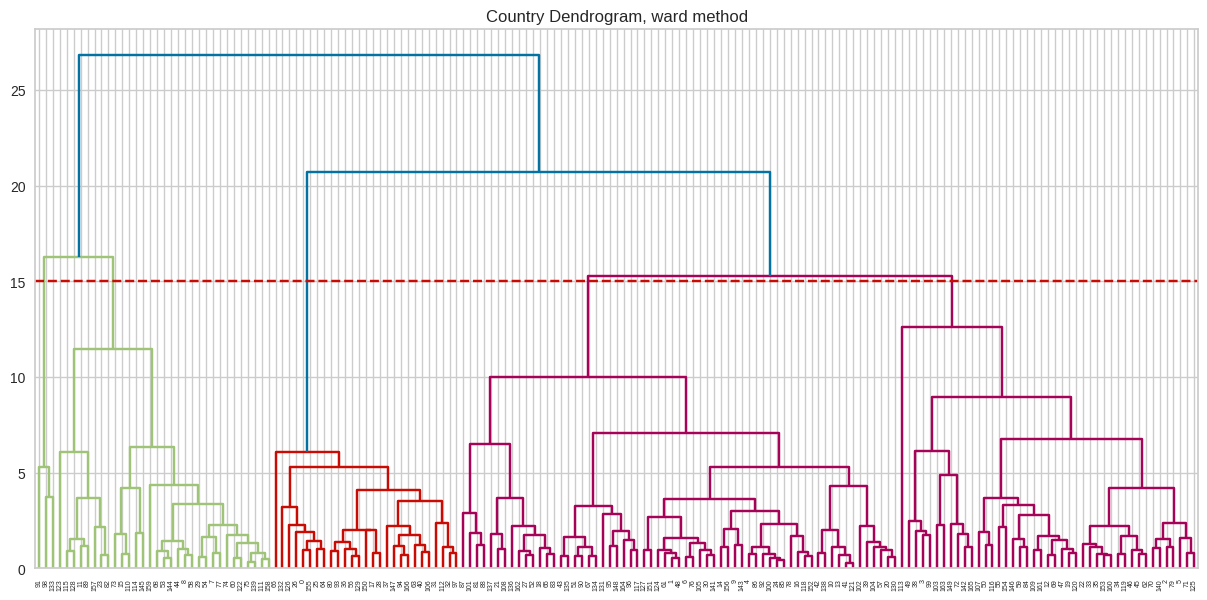

In [ ]:
#Ward linkage
plt.figure(figsize=(15, 7))
plt.title("Country Dendrogram, ward method")

clusters = shc.linkage(df1,
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 15, color = 'r', linestyle = '--')
plt.show()

Utilizaremos el metodo ward para crear un cluster jerárquico dividido en 3 grupos:

In [ ]:

clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(df1)

#¿Cómo podemos ver la asignación de las observaciones a los clusters?
clustering_model.labels_

array([2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2])

In [ ]:
#guardamos el resultado como nueva columna en el df1
df_cluster['hclust'] = clustering_model.labels_

In [ ]:
df_cluster.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp', 'principal_component_1',
       'principal_component_2', 'hclust'],
      dtype='object')

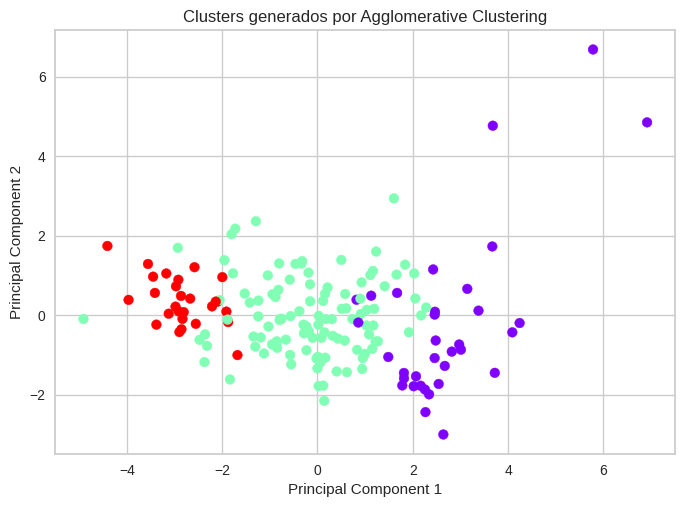

In [ ]:
# Crear un scatter plot de los datos con colores según los clusters
plt.scatter(df_cluster['principal_component_1'], df_cluster['principal_component_2'], c=df_cluster['hclust'], cmap='rainbow')
plt.title('Clusters generados por Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# K-means

In [ ]:

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# SSE: Sum of Square Error
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df1)
    sse.append(kmeans.inertia_)

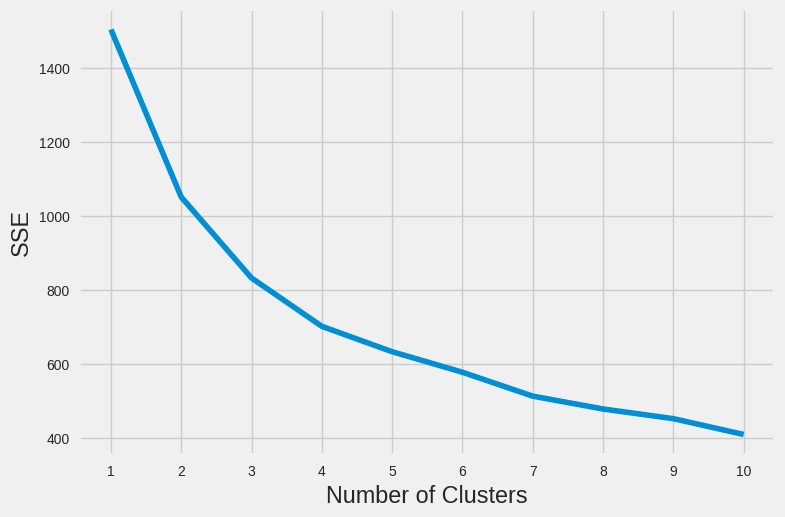

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

el mejor k para el k-means cluster es 4:

In [ ]:
kmeans_4 = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans_4.fit(df1)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [ ]:
#¿Donde estan los centroides de los clusters que generó?
kmeans_4.cluster_centers_

array([[-0.84900324,  4.93567278, -0.00816303,  4.54805768,  2.4395424 ,
        -0.50420614,  1.22682431, -1.03886271,  2.44079735],
       [ 1.34541883, -0.45967186, -0.1895969 , -0.22567743, -0.68713515,
         0.39226703, -1.26429235,  1.32908188, -0.60530769],
       [-0.82787747,  0.16811209,  0.88737767, -0.30560645,  1.48891727,
        -0.47955552,  1.1087252 , -0.75076544,  1.70196967],
       [-0.43706491,  0.02737909, -0.19090588,  0.06955093, -0.20131886,
        -0.03918493,  0.28566125, -0.44720856, -0.31752579]])

In [ ]:
#Y la asignación de las observaciones a cada cluster...
kmeans_4.labels_

array([1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 1,
       3, 2, 3, 1, 1, 3, 1, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 2, 3,
       2, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 1, 1, 3, 2, 1, 2, 3, 3, 1, 1, 3,
       1, 3, 2, 3, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 1, 3, 3, 1,
       1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3,
       2, 2, 1, 1, 2, 3, 1, 3, 3, 3, 3, 3, 2, 2, 3, 3, 1, 3, 3, 1, 3, 3,
       1, 0, 3, 2, 3, 1, 3, 2, 3, 3, 1, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3,
       3, 1, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1], dtype=int32)

In [ ]:
df_cluster['kmeans(4)'] = kmeans_4.labels_

In [ ]:
df_cluster

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,principal_component_1,principal_component_2,hclust,kmeans(4)
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,-2.913025,0.095621,2,1
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0.429911,-0.588156,1,3
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,-0.285225,-0.455174,1,3
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,-2.932423,1.695555,1,1
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,1.033576,0.136659,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913,-0.820631,0.639570,1,3
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323,-0.551036,-1.233886,1,3
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754,0.498524,1.390744,1,3
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754,-1.887451,-0.109453,1,1


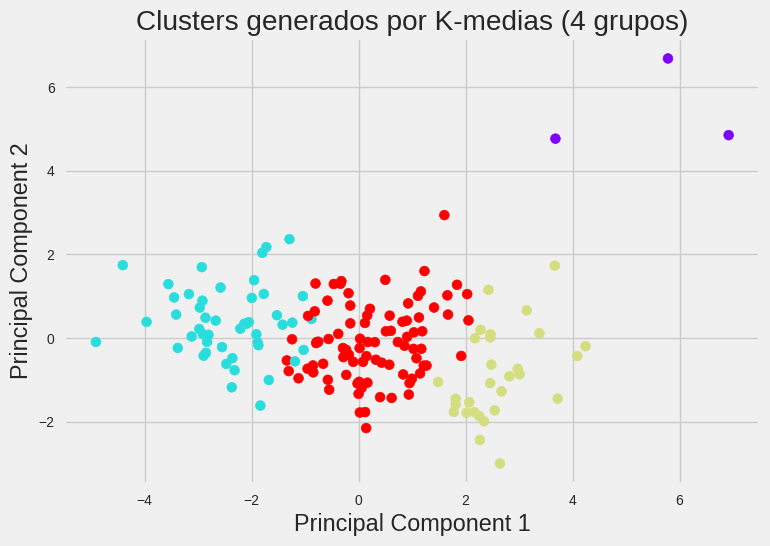

In [ ]:
# Crear un scatter plot de los datos con colores según los clusters
plt.scatter(df_cluster['principal_component_1'], df_cluster['principal_component_2'], c=df_cluster['kmeans(4)'], cmap='rainbow')
plt.title('Clusters generados por K-medias (4 grupos)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

notamos que uno de los grupos del cluster es mas bien un grupo de outliers, por lo tanto podriamos decidir eliminarlos o incluirlos en uno de los 3 grupos.

K-means de 3 grupos

In [ ]:
kmeans_3 = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans_3.fit(df1)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [ ]:
df_cluster['kmeans(3)'] = kmeans_3.labels_

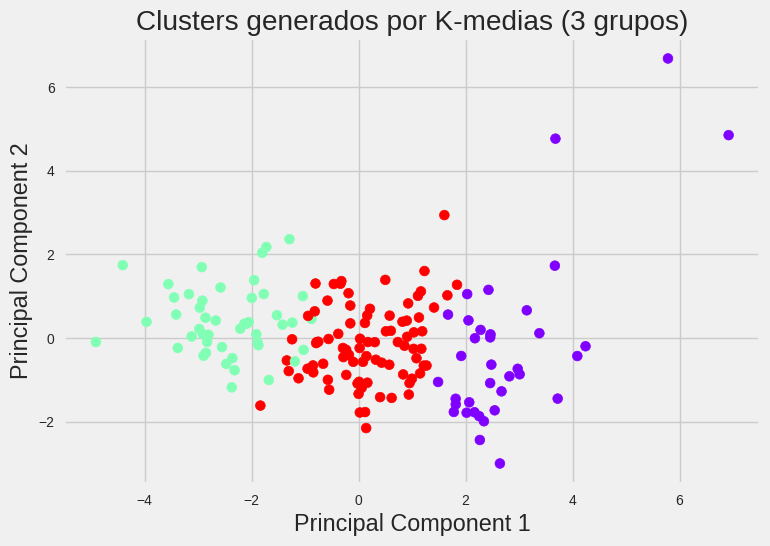

In [ ]:

plt.scatter(df_cluster['principal_component_1'], df_cluster['principal_component_2'], c=df_cluster['kmeans(3)'], cmap='rainbow')
plt.title('Clusters generados por K-medias (3 grupos)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# DBSCAN

Text(0, 0.5, 'Distancia')

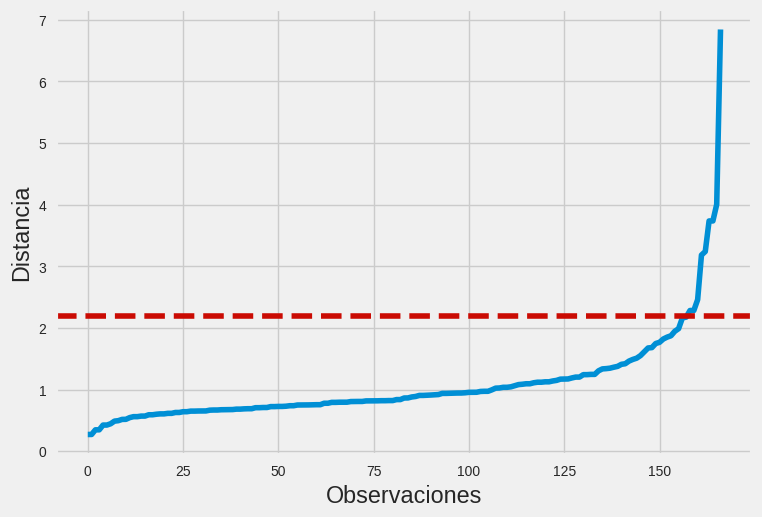

In [ ]:
k = 2
data_nn = df1.copy()

# Calculamos los vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Obtenemos las distancias
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)
plt.axhline(y = 2.2, color = 'r', linestyle = '--')
plt.xlabel("Observaciones")
plt.ylabel("Distancia")

In [ ]:
#Realizamos el clustering
dbscan_clusters = DBSCAN(eps = 2.2, min_samples = 5).fit(df1)

In [ ]:
#Las observaciones que quedan con un valor de -1 son los puntos ruido (o outliers). Por lo que son las observaciones que no asignó a ningun cluster
dbscan_clusters.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0])

In [ ]:
df_cluster['dbscan'] = pd.Series(dbscan_clusters.labels_)

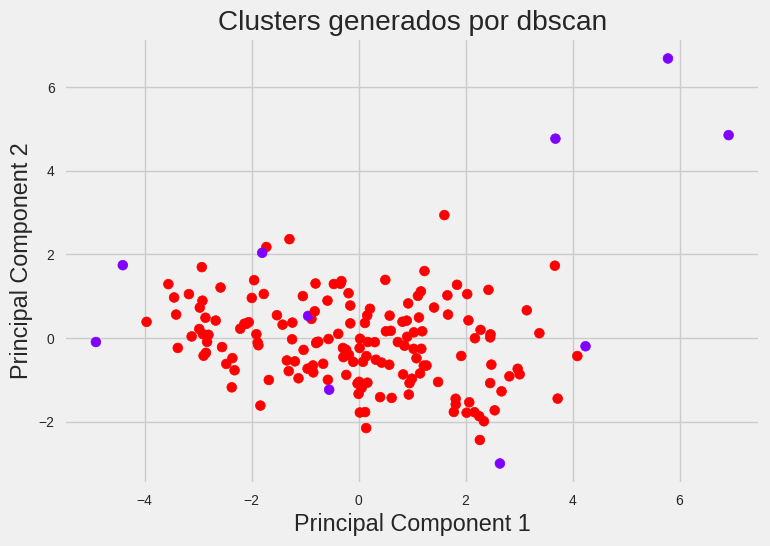

In [ ]:
plt.scatter(df_cluster['principal_component_1'], df_cluster['principal_component_2'], c=df_cluster['dbscan'], cmap='rainbow')
plt.title('Clusters generados por dbscan')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Evaluación de los distintos métodos de clustering

## Validación interna

Davies-Bouldin Score

In [ ]:
#Clustering Jerarquico
davies_bouldin_score(df1, df_cluster['hclust'])

1.299788958694555

In [ ]:
#k-means, 3 grupos
davies_bouldin_score(df1, df_cluster['kmeans(3)'])

1.2769056099698288

In [ ]:
#k-means, 4 grupos
davies_bouldin_score(df1, df_cluster['kmeans(4)'])

1.0419060938611253

Silhoutte Score

In [ ]:
#Clustering Jerarquico
silhouette_score(df1, df_cluster['hclust'])

0.24563001303300652

In [ ]:
#k-means, 3 grupos
silhouette_score(df1, df_cluster['kmeans(3)'])

0.28329575683463126

In [ ]:
#k-means, 4 grupos
silhouette_score(df1, df_cluster['kmeans(4)'])

0.303676957667828

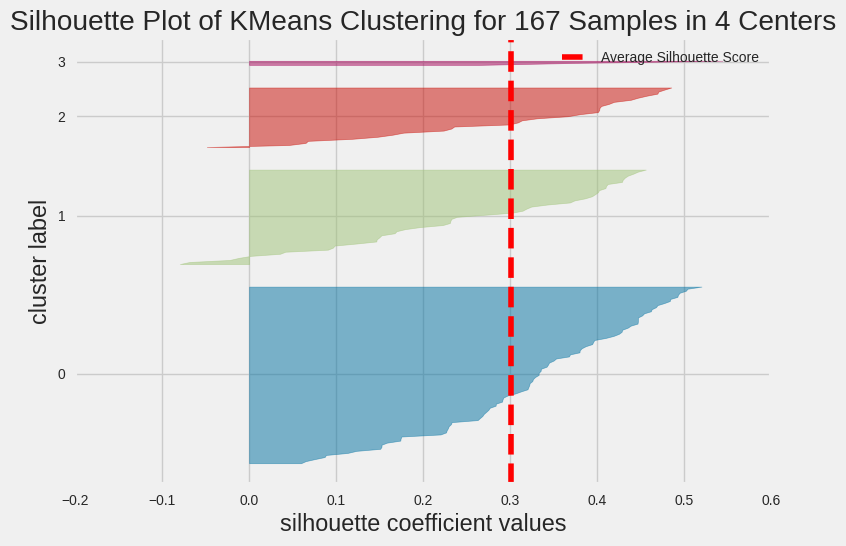

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 167 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, n_init=10, random_state=42))

In [ ]:
#Kmeans con k=4
silhouette_visualizer(KMeans(4, n_init=10, random_state=42), df1, colors='yellowbrick')

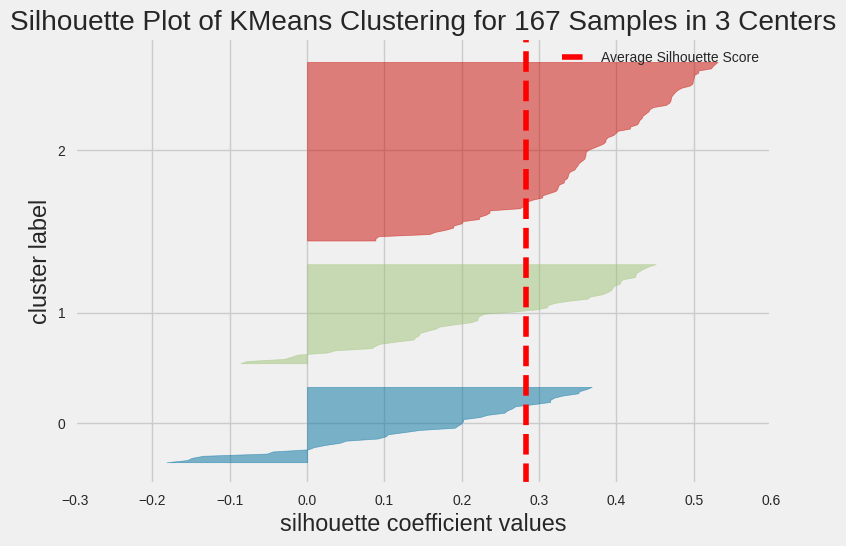

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 167 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [ ]:
#Kmeans con k=3
silhouette_visualizer(KMeans(3, n_init=10, random_state=42), df1, colors='yellowbrick')

Podemos apreciar que aparentemente el mejor método de cluster es el k-medias dividiendo en 4 grupos. Aunque sería prudente pensar que el grupo más pequeño podría ser nada más que un conjunto de outliers.

# Agragamos la columna de paises:

In [ ]:
concatenated_df = pd.concat([df_cluster, df['country']], axis=1)

In [ ]:
df_cluster

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,principal_component_1,principal_component_2,hclust,kmeans(4),kmeans(3),dbscan
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,-2.913025,0.095621,2,1,1,0
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0.429911,-0.588156,1,3,2,0
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,-0.285225,-0.455174,1,3,2,0
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,-2.932423,1.695555,1,1,1,0
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,1.033576,0.136659,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913,-0.820631,0.639570,1,3,2,0
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323,-0.551036,-1.233886,1,3,2,-1
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754,0.498524,1.390744,1,3,2,0
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754,-1.887451,-0.109453,1,1,1,0


In [ ]:
import plotly.express as px

scatter_df = concatenated_df[['principal_component_1', 'principal_component_2', 'country', 'kmeans(4)']]

fig = px.scatter(scatter_df, x='principal_component_1', y='principal_component_2', color='kmeans(4)',
                 hover_name='country', title='Clusters de países',
                 labels={'principal_component_1': 'Principal Component 1', 'principal_component_2': 'Principal Component 2'})

fig.update_traces(marker=dict(size=12, opacity=0.8))
fig.show()



# Bonus Track- PCA como parte del preprocesamiento:*

In [ ]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(df1)

# Convertimos el resultado en un dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.913025,0.095621,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148
1,0.429911,-0.588156,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316
2,-0.285225,-0.455174,1.221505,-0.868115,0.156475,-0.401696,-0.087214,-0.184162,0.084037
3,-2.932423,1.695555,1.525044,0.839625,-0.273209,-0.547996,-0.440835,-0.355998,-0.091339
4,1.033576,0.136659,-0.225721,-0.847063,-0.193007,-0.206919,0.241978,-0.023681,0.094270
...,...,...,...,...,...,...,...,...,...
162,-0.820631,0.639570,-0.389923,-0.706595,-0.395748,0.009059,-0.098738,0.521886,-0.497803
163,-0.551036,-1.233886,3.101350,-0.115311,2.082581,0.097274,0.206735,-0.078805,-0.275735
164,0.498524,1.390744,-0.238526,-1.074098,1.176081,0.051607,-0.143627,-0.217590,-0.036522
165,-1.887451,-0.109453,1.109752,0.056257,0.618365,-0.540917,0.060256,0.089495,-0.096049


In [ ]:
pca.explained_variance_ratio_

array([0.4595174 , 0.17181626, 0.13004259, 0.11053162, 0.07340211,
       0.02484235, 0.0126043 , 0.00981282, 0.00743056])

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", title="% Varianza Explicada", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", title="% Varianza Acumulada", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<Axes: title={'center': '% Varianza Explicada'}, xlabel='Componente'>,
       <Axes: title={'center': '% Varianza Acumulada'}, xlabel='Componente'>],
      dtype=object)

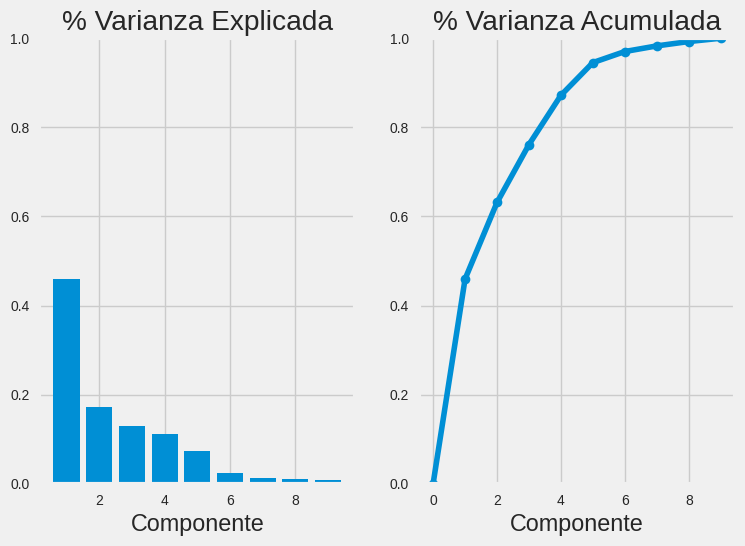

In [ ]:
# Look at explained variance
plot_variance(pca)

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=df1.columns,
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
child_mort,-0.419519,0.192884,-0.029544,0.370653,-0.168970,0.200628,-0.079489,-0.682743,0.327542
exports,0.283897,0.613163,0.144761,0.003091,0.057616,-0.059333,-0.707303,-0.014197,-0.123082
health,0.150838,-0.243087,-0.596632,0.461897,0.518000,0.007276,-0.249831,0.072497,0.113088
imports,0.161482,0.671821,-0.299927,-0.071907,0.255376,-0.030032,0.592190,-0.028946,0.099037
income,0.398441,0.022536,0.301548,0.392159,-0.247150,0.160347,0.095562,0.352624,0.612982
inflation,-0.193173,-0.008404,0.642520,0.150442,0.714869,0.066285,0.104633,-0.011538,-0.025236
life_expec,0.425839,-0.222707,0.113919,-0.203797,0.108220,-0.601127,0.018486,-0.504664,0.294040
total_fer,-0.403729,0.155233,0.019549,0.378304,-0.135262,-0.750689,0.028826,0.293353,-0.026336
gdpp,0.392645,-0.046022,0.122977,0.531995,-0.180167,0.016779,0.242998,-0.249696,-0.625646


<Axes: >

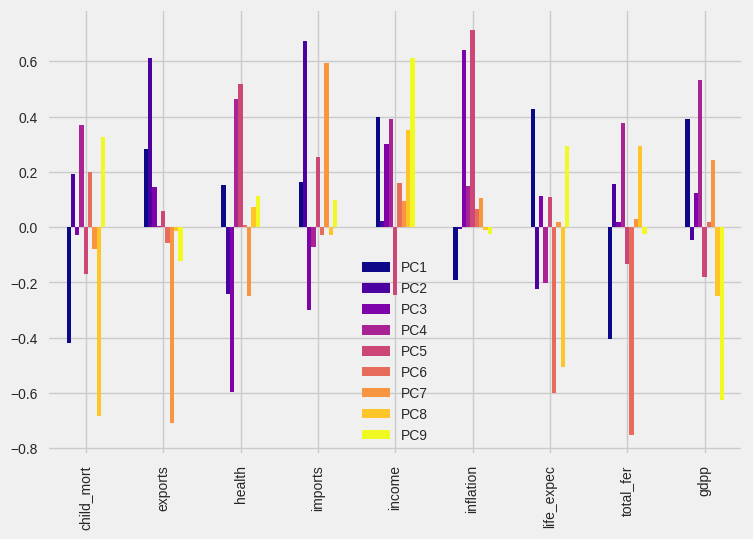

In [ ]:
loadings.plot(kind='bar', cmap='plasma')

Text(0.5, 1.0, 'PC1 composition')

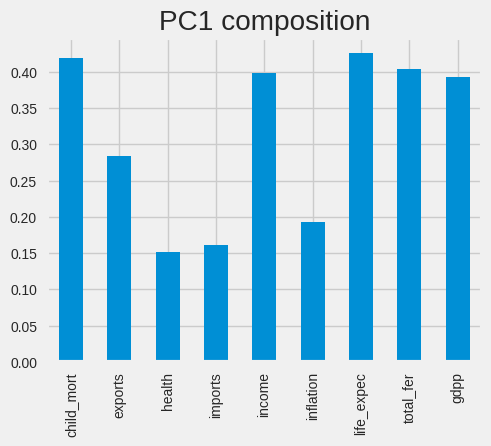

In [ ]:
loadings['PC1'].abs().plot(kind='bar', figsize=(5,4))
plt.title('PC1 composition')